In [154]:
import numpy as np
import pandas as pd
import sklearn.metrics
from sklearn.cluster import AgglomerativeClustering
from operator import itemgetter
from tqdm.notebook import tqdm
tqdm().pandas()

TRAIN_DAT = '/w/225/1/chess/tactics/parameter_tuning_files/train_full_set'
CONTEXT_DAT = '/w/225/1/chess/tactics/parameter_tuning_files/cv_full_set'
VOCAB_DAT = '/w/225/1/chess/tactics/parameter_tuning_files/wv_full_set'

/h/224/stevenhl/miniconda3/envs/chess/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
train_dat = pd.read_csv('/w/225/1/chess/tactics/glicko_user_tactics_problem.csv_00')
train_dat = train_dat[train_dat.is_passed == 1]

In [3]:
#Set up range of hyperparamters to try for tuning
param1 = "alpha"
#param1_values = np.array([0.02, 0.04, 0.06, 0.08, 0.1])
param1_values = np.array([0.16])
param2 = "size"
#param2_values = np.array([262, 265, 268, 271, 274])
param2_values = np.array([265])

param3 = "negative"
#param3_values = np.array([26, 27, 28, 29, 30])
param3_values = 28

param4 = "sample"
#param4_values = np.array([0.35, 0.4, 0.45, 0.55, 0.6])
param4_values = 0.35

print(param1_values)
print(param2_values)

#print(param3_values)
#print(param4_values)

all_embeddings = [(p1, p2) for p1 in param1_values for p2 in param2_values]
#all_embeddings = [(p3, p4) for p3 in param3_values for p4 in param4_values]

[0.16]
[265]


In [4]:
import subprocess
import sys

def generate_embedding(tpl):
    #p3, p4 = tpl
    #p1, p2 = tpl
    p1 = 0.16
    p2 = 265
    output = f"word2vecf/vectors/size_alpha/vecs_{p1}_{p2}.txt"
    #output = f"word2vecf/vectors/negative_sample/vecs_{p3}_{p4}.txt"
    command = f"word2vecf/word2vecf -train {TRAIN_DAT} -wvocab {VOCAB_DAT} -cvocab {CONTEXT_DAT} -output {output} -threads 180 -{param1} {p1} -{param2} {p2} -negative 28 -sample 0.35"
    #command = f"word2vecf/word2vecf -train {TRAIN_DAT} -wvocab {VOCAB_DAT} -cvocab {CONTEXT_DAT} -output {output} -threads 180 -alpha 0.15 -size 250 - {param3} {p3} -{param4} {p4}"
    
    subprocess.run(command, shell=True)
    
    with open(output) as myfile:
        head = [next(myfile) for x in range(5)]
    print(head)
    
    return output
    
#generated_embeddings = list(map(generate_embedding, tqdm(all_embeddings)))
generated_embeddings = generate_embedding(all_embeddings)

['42278 265\n', '731 -0.115115 0.185752 0.033555 0.204703 -0.189592 0.005616 0.306501 0.114872 0.377216 0.142595 -0.086493 0.053763 -0.033068 0.313770 -0.224773 -0.273395 -0.157763 0.061952 -0.119237 -0.159254 -0.110432 0.146356 -0.060756 0.406304 0.336782 -0.159991 0.012881 -0.139996 0.003351 0.278163 -0.017320 -0.126085 -0.061798 -0.032756 -0.033878 0.063953 0.025655 -0.183091 0.402320 0.031571 -0.078153 0.085933 0.408063 0.203141 0.118829 -0.326797 -0.013338 0.251348 -0.228176 -0.079299 0.345559 0.096236 -0.114002 -0.105052 0.432448 0.080130 -0.367048 -0.165755 0.094678 0.236926 0.244592 -0.275352 0.067435 0.007485 -0.062490 -0.103130 -0.008996 0.035399 -0.518256 0.111729 0.084146 -0.262558 0.253333 0.060481 0.121916 0.145654 -0.280428 0.015922 -0.238470 0.165110 -0.303779 -0.206641 -0.051113 -0.081672 0.436679 0.333620 0.516720 -0.327601 0.444172 -0.687877 0.283904 -0.093890 -0.136383 0.014685 0.409236 0.615993 -0.341768 -0.392257 -0.188690 -0.056385 0.032435 -0.016446 0.090625 0.1

In [145]:
temp = pd.read_csv(generated_embeddings, sep=' ', header=None, skiprows=1)
temp = temp.drop(len(temp.columns)-1,axis=1)
problem_id = list(temp[0])
temp = temp.drop(0, axis = 1)
temp = temp.divide(np.linalg.norm(temp, axis=1), axis=0)

In [146]:
sample_size = 1000
sampled_problems = np.random.choice(problem_id, size = sample_size, replace = False)
sampled_problems = list(sampled_problems)

In [147]:
def embedding_list(sampled_problems):
    for i in range(len(sampled_problems)):
        pos = problem_id.index(sampled_problems[i])
        embedding = list(temp.iloc[pos,:])
        sampled_problems[i] = embedding
    return sampled_problems

In [148]:
cos_sim = sklearn.metrics.pairwise.cosine_similarity(embedding_list(sampled_problems))
cos_dist = 1 - cos_sim

In [149]:
cluster = AgglomerativeClustering(n_clusters = 5, affinity='precomputed', linkage='complete')
res = cluster.fit(cos_dist)
labels = list(res.labels_)
prob_pair = list(zip(problem_id, labels))
prob_pair_sorted = sorted(prob_pair, key=itemgetter(1))

In [151]:
problem_id_grouped = [x[0] for x in prob_pair_sorted]
cos_sim_grouped = sklearn.metrics.pairwise.cosine_similarity(embedding_list(problem_id_grouped))

In [171]:
cos_sim_grouped

(1000, 1000)

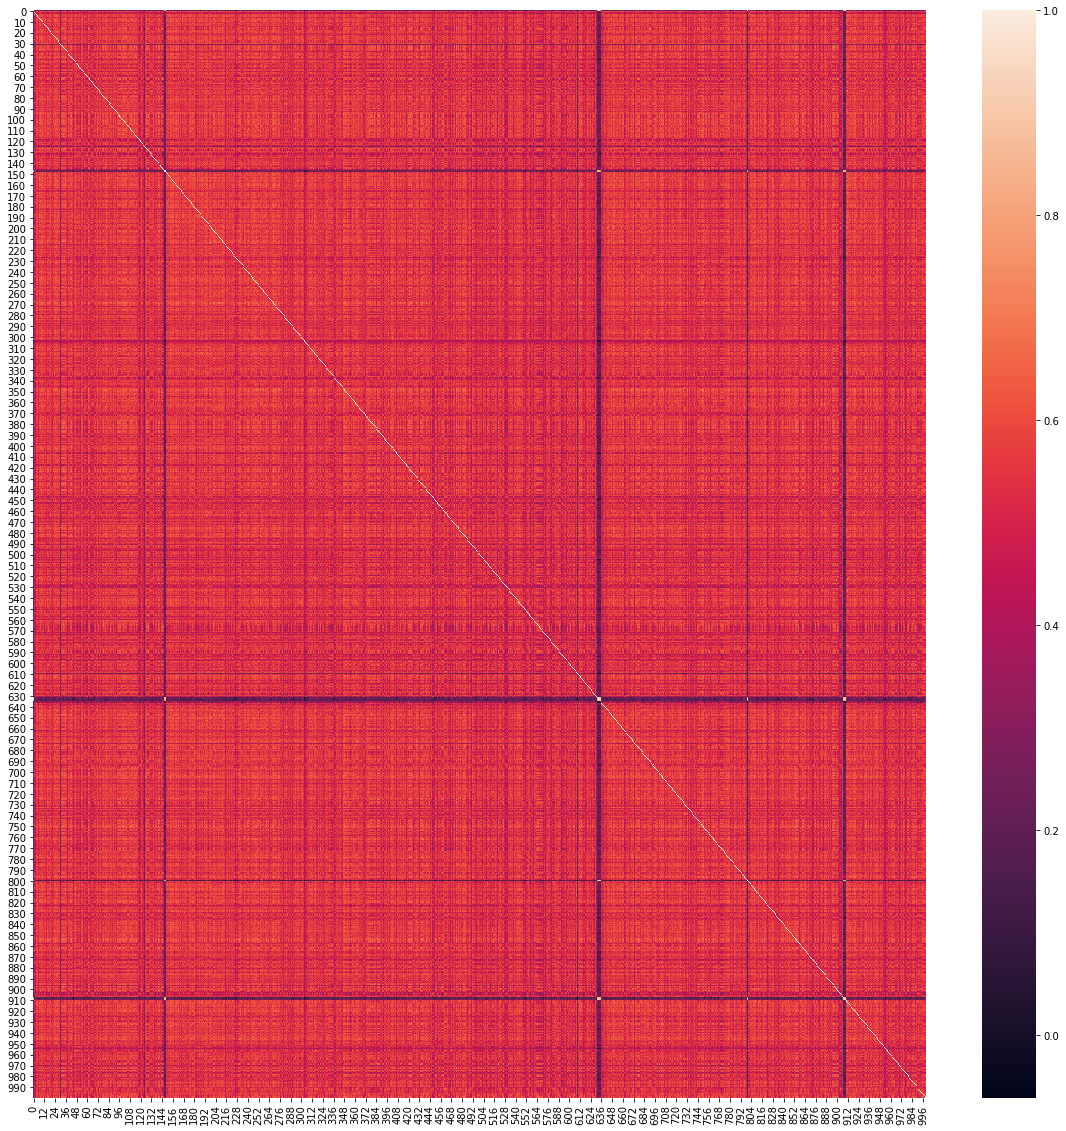

In [181]:
import seaborn as sb
import matplotlib.pyplot as plt
plt.subplots(figsize=(20,20))
#sb.heatmap(cos_sim_grouped, xticklabels = problem_id_grouped, yticklabels = problem_id_grouped)
sb.heatmap(cos_sim_grouped)

(array([1.16000e+02, 2.73200e+03, 1.62440e+04, 2.12980e+04, 1.53194e+05,
        5.15502e+05, 2.87984e+05, 1.82400e+03, 7.80000e+01, 1.02800e+03]),
 array([-0.06130919,  0.04482173,  0.15095265,  0.25708356,  0.36321448,
         0.4693454 ,  0.57547632,  0.68160724,  0.78773816,  0.89386908,
         1.        ]),
 <a list of 10 Patch objects>)

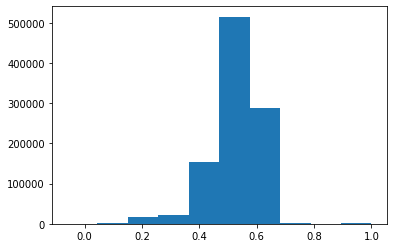

In [190]:
cos_sim_flatten = [item for sublist in cos_sim_grouped for item in sublist]
plt.hist(cos_sim_flatten, 10)